# Data wrangling<a id='2_Data_wrangling'></a>

## 1.1 Introduction

The data set being explored is provided by the BioCircutis Institute at the University of California San Diego, and is hosted on the UCI Machine Learning Repository through the following link. http://archive.ics.uci.edu/ml/datasets/Gas+Sensor+Array+Drift+Dataset+at+Different+Concentrations

**The following information has been provided for the data set from the above link:**

"This data set contains 13,910 measurements from 16 chemical sensors exposed to 6 gases at different concentration levels. This dataset is an extension of the Gas Sensor Array Drift Dataset ([Web Link]), providing now the information about the concentration level at which the sensors were exposed for each measurement. The primary purpose of making this dataset freely accessible on-line is to provide an extensive dataset to the sensor and artificial intelligence research communities to develop and test strategies to solve a wide variety of tasks, including sensor drift, classification, regression, among others.

The dataset can be used exclusively for research purposes. Commercial purposes are fully excluded. Citation of both Vergara et al. 'Chemical gas sensor drift compensation using classifier ensembles' and Rodriguez-Lujan et al. 'On the calibration of sensor arrays for pattern recognition using the minimal number of experiments' is required.

The dataset was gathered during the period of January 2008 to February 2011 (36 months) in a gas delivery platform facility situated at the ChemoSignals Laboratory in the BioCircuits Institute, University of California San Diego. The measurement system platform provides versatility for obtaining the desired concentrations of the chemical substances of interest with high accuracy and in a highly reproducible manner, minimizing thereby the common mistakes caused by human intervention and making it possible to exclusively concentrate on the chemical sensors. See reference 1 for more details on the experimental setup."

## 1.2 Imports

In [1]:
import numpy as np
import pandas as pd
import os
import re
import matplotlib.pyplot as plt
import seaborn as sns
import collections

## 1.3 Objectives

There will be three objectives for this data and the analysis to follow

1.  Accurately predict which chemical the sensors were exposed to
2.  Accurately predict the concentration level of the chemical exposed to the sensors
3.  Determine if the sensors drift (readings change over time for the same chemical and concentration)

However, for this notebook the only objective is to determine if the quality of the data provided and what should be done if there is a quality concern

## 1.4 Function Definitions

In [2]:
#import the file and read all lines as strings
def import_dat(batch_file, rd_path):
    """
    Function for importing .dat files. Each line is read in as a string and broken up based on spaces between entries.
    It is expected that there is a ';' in the first string chunk, and multiple ':' throughout.
    Column names are manually created and entered here so it only work for the Gas Sensor Array Drift Dataset at Different Concentrations Data Set
    
    Inputs:
        batch_file - (str) filename of the specfic batch data
        rd_path - (str) folder location of where the batch file is located
    Outputs:
        batch_data - (DataFrame) batch file data in an easier to read format
    """
    with open(rd_path + '\\' + batch_file, 'r') as file: #open the file as read only
        lines = file.readlines() #save the data as a list of string lines before closing

    fd = [] # initialize a list for the formatted data
    for line in lines:
        row_list = line.split() #split the line up to get the column values for a given row
        predict_vals = [float(i[i.index(':')+1:]) for i in row_list[1:]] #extract the predictor variable values
        target_vals = [row_list[0][:row_list[0].index(';')], float(row_list[0][row_list[0].index(';') + 1:])] #extract the two target variables, chemcial number & concentration
        fd.append(predict_vals + target_vals) #add the row to the formatted data list

    col_names_pat = ['DR', '|DR|', 'EMAi0.001', 'EMAi0.01', 'EMAi0.1', 'EMAd0.001', 'EMAd0.01', 'EMAd0.1'] #variable name pattern for each sensor
    col_names = [ c + '_' + str(n) for n in range(1,17) for c in col_names_pat] #use the pattern to create column names for all 16 sensors
    col_names = col_names + ['ChemicalCode', 'Concentration'] #add the two target variable names
    batch_data = pd.DataFrame(fd, columns = col_names)
    batch_data['BatchNumber'] = re.findall(r'\d+', batch_file) * len(batch_data) #add the batch number as a feature
    
    return batch_data


## 1.5 Load Raw Data

Load the data that was provided through the website and saved in the raw_data folder using the function that was created in section 1.4

In [3]:
#Get the relative local folder where the data is stored
base_fpath = os.getcwd() #the file path to the working directory of the code
rd_path = base_fpath.replace('notebooks', 'raw_data') #raw data file path

#Loop through all raw data files and compile it into a single table using the import_dat function
f_data = pd.DataFrame() #initialize an empty DataFrame to store the combined data
raw_files_list = os.listdir(rd_path) #get a list of all file names in the raw_data folder
for rd_file in raw_files_list:
    batch_data = import_dat(rd_file, rd_path) #call the import_dat function on the current file
    f_data = f_data.append(batch_data, ignore_index = True) #add the data to the combined data DataFrame

Check that all of the data was imported and is formatted correctly

In [4]:
pd.set_option('display.max_columns', None) #display all columns to ensure every thing looks right
f_data.head() #display the first 5 rows of data

,DR_1,|DR|_1,EMAi0.001_1,EMAi0.01_1,EMAi0.1_1,EMAd0.001_1,EMAd0.01_1,EMAd0.1_1,DR_2,|DR|_2,EMAi0.001_2,EMAi0.01_2,EMAi0.1_2,EMAd0.001_2,EMAd0.01_2,EMAd0.1_2,DR_3,|DR|_3,EMAi0.001_3,EMAi0.01_3,EMAi0.1_3,EMAd0.001_3,EMAd0.01_3,EMAd0.1_3,DR_4,|DR|_4,EMAi0.001_4,EMAi0.01_4,EMAi0.1_4,EMAd0.001_4,EMAd0.01_4,EMAd0.1_4,DR_5,|DR|_5,EMAi0.001_5,EMAi0.01_5,EMAi0.1_5,EMAd0.001_5,EMAd0.01_5,EMAd0.1_5,DR_6,|DR|_6,EMAi0.001_6,EMAi0.01_6,EMAi0.1_6,EMAd0.001_6,EMAd0.01_6,EMAd0.1_6,DR_7,|DR|_7,EMAi0.001_7,EMAi0.01_7,EMAi0.1_7,EMAd0.001_7,EMAd0.01_7,EMAd0.1_7,DR_8,|DR|_8,EMAi0.001_8,EMAi0.01_8,EMAi0.1_8,EMAd0.001_8,EMAd0.01_8,EMAd0.1_8,DR_9,|DR|_9,EMAi0.001_9,EMAi0.01_9,EMAi0.1_9,EMAd0.001_9,EMAd0.01_9,EMAd0.1_9,DR_10,|DR|_10,EMAi0.001_10,EMAi0.01_10,EMAi0.1_10,EMAd0.001_10,EMAd0.01_10,EMAd0.1_10,DR_11,|DR|_11,EMAi0.001_11,EMAi0.01_11,EMAi0.1_11,EMAd0.001_11,EMAd0.01_11,EMAd0.1_11,DR_12,|DR|_12,EMAi0.001_12,EMAi0.01_12,EMAi0.1_12,EMAd0.001_12,EMAd0.01_12,EMAd0.1_12,DR_13,|DR|_13,EMAi0.001_13,EMAi0.01_13,EMAi0.1_13,EMAd0.001_13,EMAd0.01_13,EMAd0.1_13,DR_14,|DR|_14,EMAi0.001_14,EMAi0.01_14,EMAi0.1_14,EMAd0.001_14,EMAd0.01_14,EMAd0.1_14,DR_15,|DR|_15,EMAi0.001_15,EMAi0.01_15,EMAi0.1_15,EMAd0.001_15,EMAd0.01_15,EMAd0.1_15,DR_16,|DR|_16,EMAi0.001_16,EMAi0.01_16,EMAi0.1_16,EMAd0.001_16,EMAd0.01_16,EMAd0.1_16,ChemicalCode,Concentration,BatchNumber
0,15596.1621,1.868245,2.371604,2.803678,7.512213,-2.739388,-3.344671,-4.847512,15326.6914,1.768526,2.269085,2.713374,6.915721,-2.488324,-3.082212,-5.056975,2789.3831,2.754759,0.430440,0.649457,1.795029,-0.426662,-0.584313,-1.438976,2581.5686,2.680623,0.399746,0.605065,1.786704,-0.400115,-0.550743,-1.728611,685.3994,1.682904,0.122736,0.223703,0.584691,-0.138196,-0.236907,-0.781959,797.7738,1.742488,0.152483,0.218904,0.841862,-0.164646,-0.315720,-0.791447,3128.8489,3.605537,0.532422,0.763062,2.118983,-0.557197,-0.809953,-2.344130,3136.8778,3.555169,0.535883,0.761388,1.499244,-0.571480,-0.944425,-2.658358,13540.6738,1.765738,2.006883,2.519022,6.261430,-2.172101,-2.694967,-3.791499,13831.7539,1.746493,2.057165,2.391239,5.695234,-2.350776,-2.888766,-8.129869,3020.9191,2.819354,0.474520,0.723993,2.160130,-0.467900,-0.638167,-1.643650,2185.9741,2.949381,0.342575,0.515090,1.340477,-0.361030,-0.493482,-1.200617,862.7479,1.779291,0.165138,0.246473,1.358106,-0.187465,-0.416382,-1.058061,1059.7562,1.896047,0.198946,0.334017,0.815048,-0.204467,-0.345119,-0.969336,3357.1124,3.860647,0.580818,0.806830,1.729739,-0.619214,-1.071137,-3.037772,3037.0390,3.972203,0.527291,0.728443,1.445783,-0.545079,-0.902241,-2.654529,1,10.0,1
1,26402.0704,2.532401,5.411209,6.509906,7.658469,-4.722217,-5.817651,-7.518333,23855.7812,2.164706,4.901063,5.971392,6.978131,-4.199424,-5.221090,-7.604863,3882.9057,3.155054,0.802987,1.172245,1.570895,-0.697881,-0.944655,-1.334743,3651.0427,3.130669,0.739278,1.101765,1.428631,-0.659641,-0.915543,-1.334217,982.9490,1.933877,0.233308,0.378052,0.717916,-0.225572,-0.354591,-0.748061,1162.2378,2.039431,0.278337,0.486908,0.840494,-0.271369,-0.473164,-0.718214,4332.1543,3.990162,1.002503,1.586233,1.926608,-0.913245,-1.335612,-1.773328,4387.5284,4.011519,1.009769,1.647830,1.962858,-0.944028,-1.631468,-1.925095,20553.5645,2.108870,4.266941,5.185937,6.398693,-3.636176,-4.497039,-7.464548,22540.1933,2.222146,4.621283,5.573620,6.756039,-3.986434,-4.953663,-6.561748,4240.3011,3.262893,0.887237,1.297617,1.630074,-0.768036,-1.244472,-1.419646,3079.0621,3.399659,0.649639,0.948781,1.369550,-0.598444,-0.820868,-1.081919,1237.0131,2.067927,0.305793,0.558008,0.948564,-0.289557,-0.501078,-1.191404,1459.6356,2.149242,0.361007,0.614619,0.950204,-0.327339,-0.503861,-0.838039,4685.7753,4.277604,1.080629,1.818559,2.237534,-1.004812,-1.530519,-1.994993,4176.4453,4.281373,0.980205,1.628050,1.951172,-0.889333,-1.323505,-1.749225,1,20.0,1
2,42103.5820,3.454189,8.198175,10.508439,11.611003,-7.668313,-9.478675,-12.230939,37562.3008,2.840403,7.386357,9.511703,12.129657,-6.689464,-8.184333,-10.196169,5476.3898,3.929721,1.132118,1.717418,

The columns headers follow the correct sequence based on the meta data provided with the dataset (below), and includes the chemical and concentration information. Both the chemcial code and concentration are potential target parameters and most likely both will need to be predicted.

The BatchNumber and ChemicalCode parameters are categorical, all others are numerical.

"Thus, each feature vector contains the 8 features extracted from each particular sensor, resulting in a 128-dimensional feature vector (8 features x 16 sensors) containing all the features and organized as follows:
DR_1, |DR|_1, EMAi0.001_1, EMAi0.01_1, EMAi0.1_1, EMAd0.001_1, EMAd0.01_1, EMAd0.1_1, DR_2, |DR|_2, EMAi0.001_2, EMAi0.01_2, EMAi0.1_2, EMAd0.001_2, EMAd0.01_2, EMAd0.1_2,..., DR_16, |DR|_16, EMAi0.001_16, EMAi0.01_16, EMAi0.1_16, EMAd0.001_16, EMAd0.01_16, EMAd0.1_16
where: DR_j and |DR|_j are the R and the normalized R features, respectively. EMAi0.001_j, EMAi0.01_j, and EMAi0.1_j, are the emaR of the rising transient portion of the sensor response for Alfa 0.001, 0.01, and 0.1, respectively. EMAd0.001_j, EMAd0.01_j, and EMAd0.1_j, are emaR of the decaying transient portion of the sensor response for Alfa 0.001, 0.01, and 0.1, respectively."
-- From http://archive.ics.uci.edu/ml/datasets/Gas+Sensor+Array+Drift+Dataset+at+Different+Concentrations

## 1.6 Explore the Data

### 1.6.1 Statistical Values

In [5]:
pd.set_option('display.max_columns', 20) # reset the number of displayed rows
pd.set_option('display.max_rows', None) #display all rows to ensure every thing looks right
f_data.describe(include='all').T #show basic summary statistics on the numerical and categorical features

,count,unique,top,freq,mean,std,min,25%,50%,75%,max
DR_1,13910,NaN,NaN,NaN,50435.1,69844.8,-16757.6,6694.73,19364.4,63104.8,670687
|DR|_1,13910,NaN,NaN,NaN,6.63816,13.4864,0.088287,2.28484,3.87123,8.40062,1339.88
EMAi0.001_1,13910,NaN,NaN,NaN,12.9367,17.6101,0.0001,1.63335,4.97712,17.1892,167.08
EMAi0.01_1,13910,NaN,NaN,NaN,18.744,24.8994,0.0001,2.38684,7.25089,26.4111,226.619
EMAi0.1_1,13910,NaN,NaN,NaN,26.8907,38.1077,0.0001,4.96799,11.6807,34.8432,993.605
EMAd0.001_1,13910,NaN,NaN,NaN,-9.15866,12.7292,-131.333,-11.5872,-3.3387,-1.1269,-0.006941
EMAd0.01_1,13910,NaN,NaN,NaN,-14.4024,21.3046,-227.628,-17.2926,-4.95692,-1.67033,22.2016
EMAd0.1_1,13910,NaN,NaN,NaN,-59.9276,131.018,-1664.74,-48.4928,-14.0401,-5.21221,115.273
DR_2,13910,NaN,NaN,NaN,57340.1,64045.3,-16119.5,13287.3,37764.3,70300.8,502203
|DR|_2,13910,NaN,NaN,NaN,6.64803,15.5858,0.185164,2.77669,4.73459,8.60852,1672.36


All sensors seem to have a couple of outlier readings when comparing the max values to the mean and 75% values for all parameters except EMAd0.001 because there is approximately a 5x increase or change in sign.

However, this could be due to the fact that there supposedly was a run with a gas concentration value of 1000.


### 1.6.2 Missing Values

In [6]:
pd.set_option('display.max_rows', 20) #reset the number of displayed rows
missing = 100 * f_data.isnull().mean() #calculate the percentage of missing data for each column
missing.sort_values(ascending=False) #sort the percent missing data from greatest to least
print(missing)

DR_1             0.0
|DR|_1           0.0
EMAi0.001_1      0.0
EMAi0.01_1       0.0
EMAi0.1_1        0.0
                ... 
EMAd0.01_16      0.0
EMAd0.1_16       0.0
ChemicalCode     0.0
Concentration    0.0
BatchNumber      0.0
Length: 131, dtype: float64


There is no mising data in the data set, which is either very lucky or unlucky. If it is a complete data set and all values are correct then we are lucky. Alternatively, if missing values were filled in with a chosen value then we need to determine what value correlates to a missing data point.

### 1.6.3 Parameter Distributions

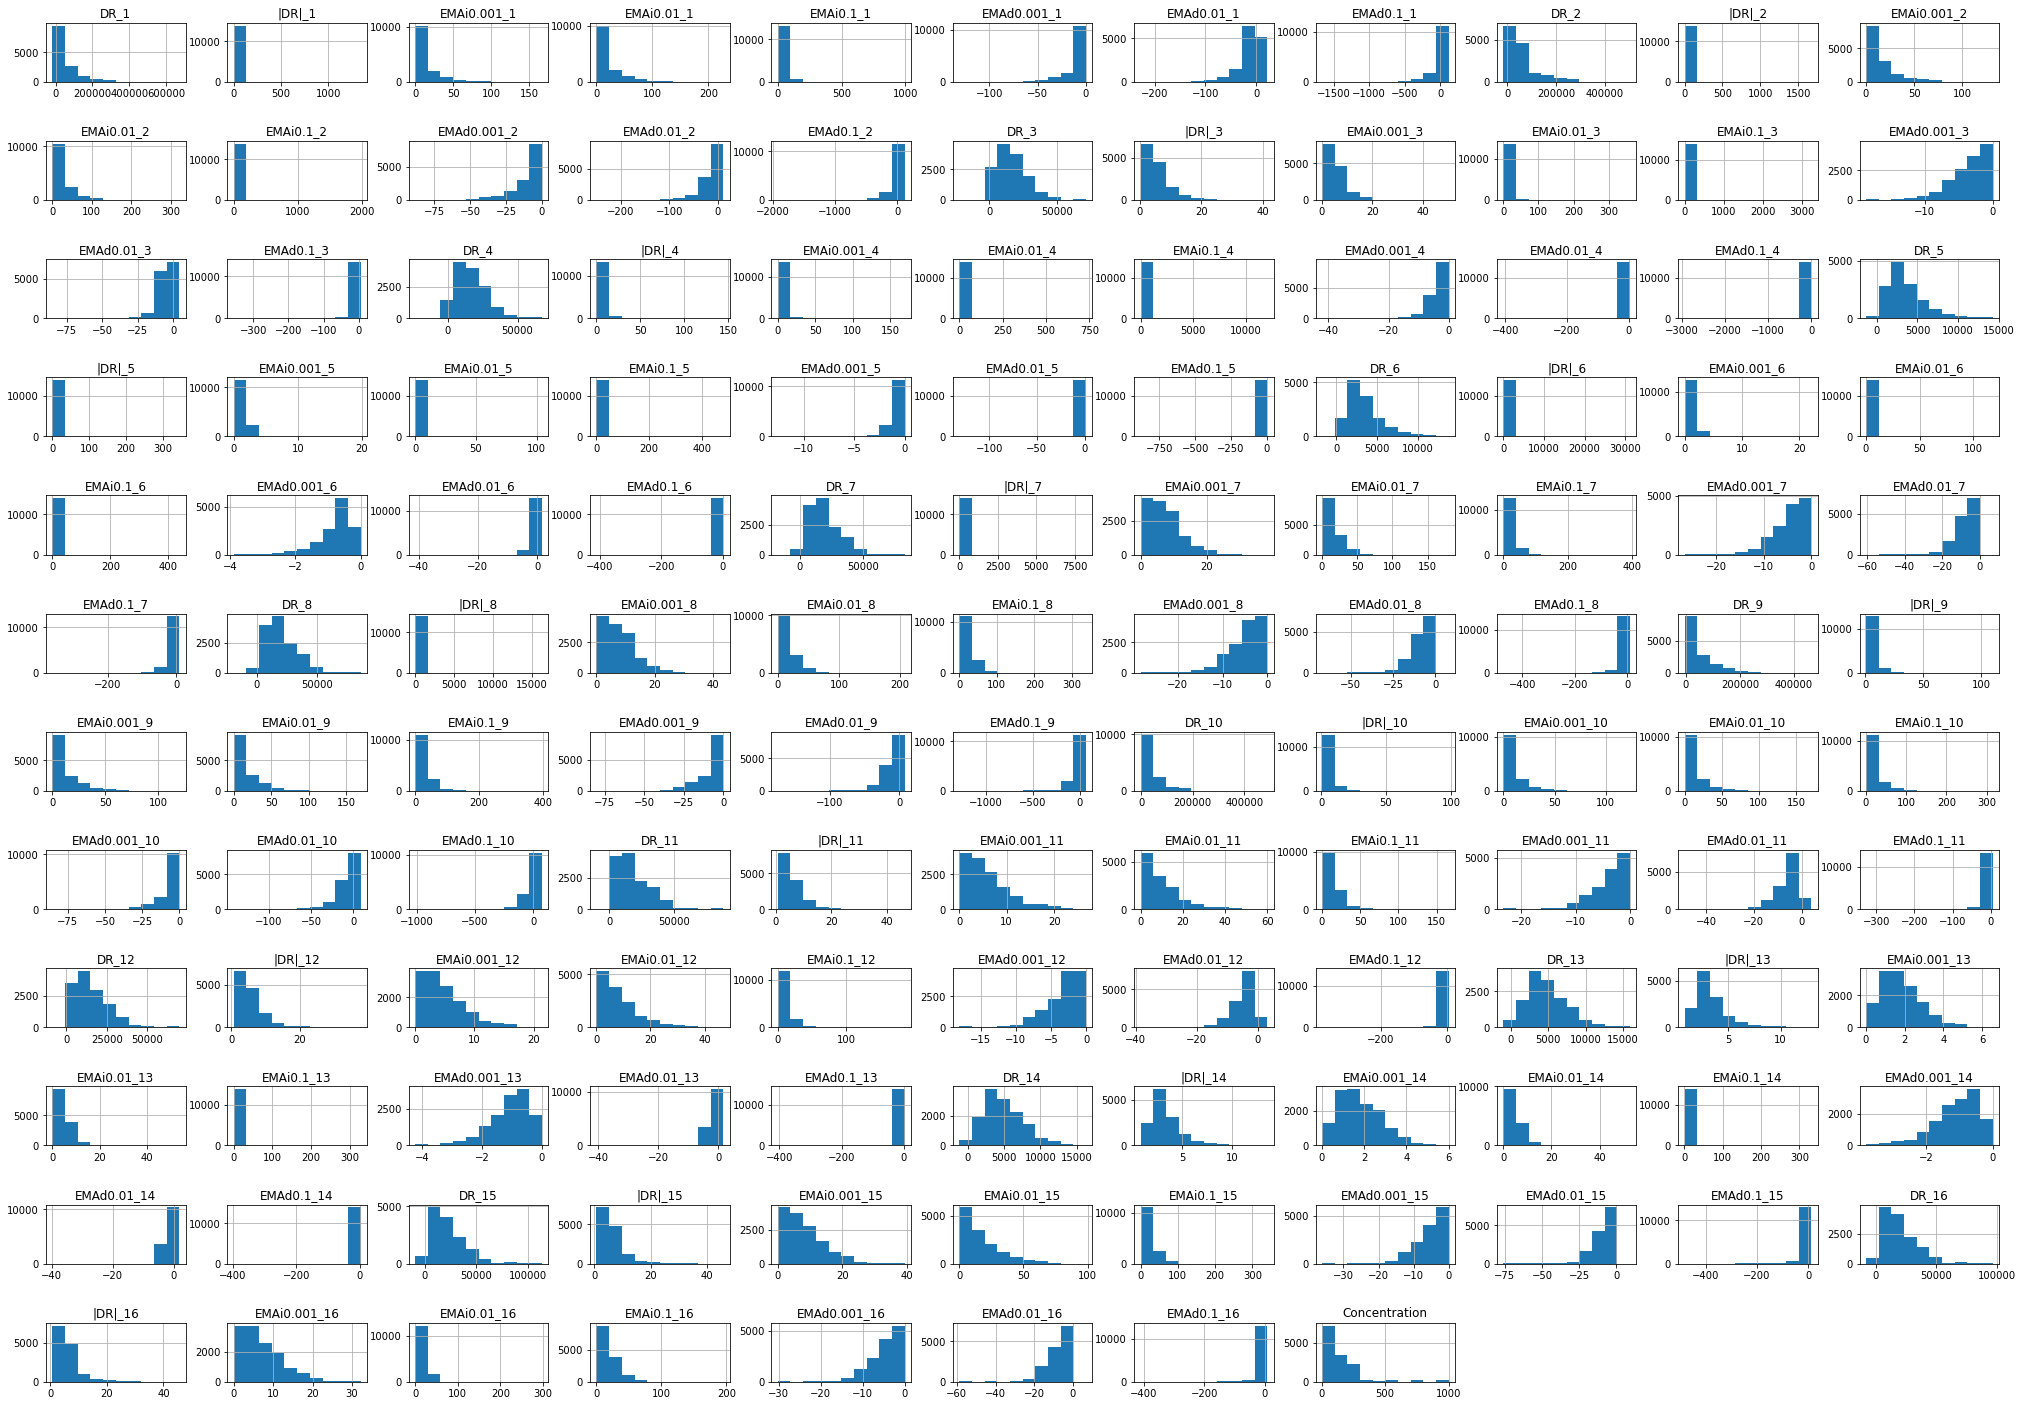

In [7]:
#Create a histogram for ever numerical parameter
f_data.hist(figsize=(35,25));
plt.subplots_adjust(hspace=1);

The distribution of values for all of the numerical features shows that the earlier suspicion was correct and a lot of the parameters have outliers since the x axis scale extends well beyond the majority of the values. The cause of these outliers is yet to be determined. Is it because the output values from the sensors are exponential? is it a couple of bad runs where data was entered incorrectly? Or is it due to the sensors breaking down?

Let's look at the rows where these outliers occur next to see if we can answer the questions above.

### 1.6.4 Outlier Investigation

An outlier is defined as being at least 1.5x the interquartile range (IQR) away from interquartile bounds. There can be mild outliers classified at 1.5x IQR and extreme outliers classified as 3x IQR. We need to determine which experimental runs had the outliers and whether or not we should keep that data or if it is suspicious.

In [8]:
# function to calculate the interquartile range - alternatively could import the scipy.stats module
def iqr(data):
    q75, q25 = np.percentile(data, [75 ,25])
    return q75 - q25

iqrs = {c : iqr(f_data[c]) for c in f_data.columns if f_data[c].dtype == float} # Calculate interquartile for each numerical parameter

In [9]:
#Determine which rows have outliers and count the number of parameters that were deemed outliers in that row
mild_out_df = pd.DataFrame() 
ex_out_df = pd.DataFrame()
for c in iqrs.keys():
    mild_out_df[c] = (f_data[c] > np.percentile(f_data[c], 75) + 1.5 * iqrs[c]) | (f_data[c] < np.percentile(f_data[c], 25) - 1.5 * iqrs[c]) #determine if the value for the given column is at least a mild outlier
    ex_out_df[c] = (f_data[c] > np.percentile(f_data[c], 75) + 3 * iqrs[c]) | (f_data[c] < np.percentile(f_data[c], 25) - 3 * iqrs[c])#determine if the value for a given column is an extreme outlier
    
n_mild_out = len(mild_out_df[mild_out_df.any(axis=1) == True]) #calculate the number of experimental runs that had at least 1 mild outlier value
n_ex_out = len(ex_out_df[ex_out_df.any(axis=1) == True]) #calculate the number of experimental runs that had at least 1 extreme outlier value

print('Number of Experimental Runs with a Mild Outlier: ' + str(n_mild_out) + ' | ' + str(round(n_mild_out/len(f_data) * 100,1)) + '% of the data')
print('Number of Experimental Runs with an Extreme Outlier: ' + str(n_ex_out) + ' | ' + str(round(n_ex_out/len(f_data) * 100,1)) + '% of the data')

#count the number of parameters that were outliers for an experimental run
print('\n') 
print('Number of Extreme Outliers per Row and Thier Frequency:')
print(ex_out_df.sum(axis=1).value_counts().head(10))

Number of Experimental Runs with a Mild Outlier: 4915 | 35.3% of the data
Number of Experimental Runs with an Extreme Outlier: 2668 | 19.2% of the data


Number of Extreme Outliers per Row and Thier Frequency:
0    11242
1      569
2      315
3      261
4      243
6      185
8      157
5      148
7      135
9       88
dtype: int64


It looks like having at outliers occuring during an experimental run is more so the rule instead of the exception with 35.3% of the data having at least one mild outlier, and 19.2% having at least one extreme outlier. Given this information the outlier data points are most likely a result of the experimentation and not missing values filled in with an extreme number since this would mean a significant portion of the data is bad. to further verify lets check if there is any correlation between the number of outliers and the concentration of the gasses.

### 1.6.5 Outlier Conclusions & Duplicate Values

In [10]:
f_data['Concentration'].corr(ex_out_df.sum(axis=1)) #correlation between the chemical concentration and the number of outliers in a given run

0.6093891918282509

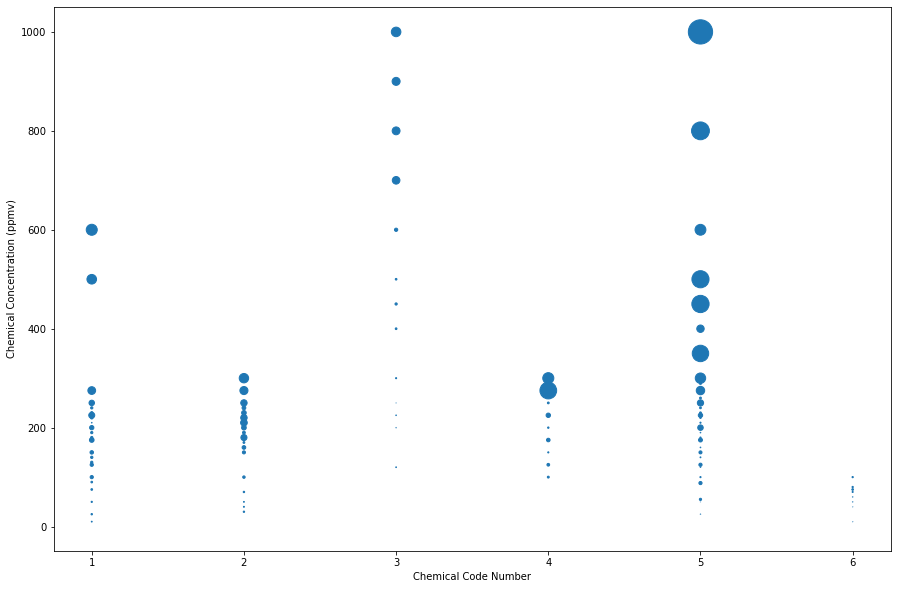

In [14]:
#dataframe of the two target parameters and the number of outliers in a given run
combined = pd.concat([f_data['Concentration'], f_data['ChemicalCode'], ex_out_df.sum(axis=1)], axis = 1) 
combined.columns = ['Concentration', 'ChemicalCode', 'NumOutliers']

grouped = combined.groupby(['ChemicalCode', 'Concentration']).agg('mean') #calculate the mean number of outliers per row for each combination of the two target parameters

#transform the double indexed group back into a dataframe
grouped['Concentration'] = grouped.index.get_level_values(1)
grouped = grouped.droplevel(1)
grouped.reset_index(inplace = True)

#plot the test parameter combinations and display buble size is the average number of outlie values
plt.figure(figsize=(15,10))
plt.scatter(grouped['ChemicalCode'], grouped['Concentration'], grouped['NumOutliers']*10)
plt.xlabel('Chemical Code Number')
plt.ylabel('Chemical Concentration (ppmv)');

Based on the graph the correlation calculated before seems accurate since the bubbles get bigger the greater the concentration. Perhaps the reason the percentage of outliers is so high is due to the entire data set being used when calculating the iqr. By breaking the data up based on the concentration, chemical and even batch number we might not see any outliers at all. Instead what should be focused on is if there might be any erroneous data, such that if any missing data was replaced with a very large number or very small number causing it to show up as an outlier. If that is the case we must assume that the data organizers would have chosen a consistent value, so we need to look for any value that shows up at a relatively high frequency.

In [68]:
print('Number of Rows that are Duplicates: ' + str(len(f_data[f_data.duplicated(keep=False) == True])))

d_list = []
#create a list of all numerical values that are duplicates and are not target parameters or the batch number
for c in f_data.columns:
    if c not in ['Concentration', 'ChemicalCode', 'BatchNumber']:
        d_list += f_data[c][f_data.duplicated(c, keep = False) == True].tolist()
        
dup_counts = collections.Counter(d_list) #get a count of each value that has at least one duplicate

#transfrom the counter dictionary of numerical values and counts to a sorted data frame
dup_counts_df = pd.DataFrame.from_dict(dup_counts, orient = 'index').sort_values(by=0, ascending = False) 
dup_counts_df.rename({0:'NumDuplicates'}, axis=1, inplace=True)
dup_counts_df.index.rename('NumericalValue', inplace=True)
print('\n')
print(dup_counts_df.head()) #print the top 5 most frequent numerical values

Number of Rows that are Duplicates: 0


                NumDuplicates
NumericalValue               
 0.000100                  61
 0.000000                  54
 1.000000                  16
-0.095939                   3
 0.773505                   3


There are a couple of values that are repeated multiple times, but they are not outliers so none of the data will be deleted.

## 1.7 Save Data

In [70]:
cd_path = base_fpath.replace('notebooks', 'data') #cleaned data file path
f_data.to_csv(cd_path + '/gas_data_cleaned.csv', index=False)